# QoE (Quality of Experience) Prediction

This notebook builds a regression model to predict Mean Opinion Score (MOS) from network
metrics and application context. Understanding QoE drivers enables proactive network
management and SLA optimization.

## 1. Setup & Configuration

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_style("whitegrid")
sns.set_palette("husl")

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

In [2]:
import sys
sys.path.insert(0, "../src")

RANDOM_STATE = 42
DATA_PATH = "../data/raw/qoe_prediction_raw.parquet"
TARGET_COL = "mos_score"

np.random.seed(RANDOM_STATE)
print("Environment ready.")

Environment ready.


## 2. Data Loading & Validation

In [3]:
df = pd.read_parquet(DATA_PATH)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()

Dataset shape: (10000, 13)
Columns: ['session_id', 'timestamp', 'network_type', 'device_class', 'app_type', 'sinr_db', 'throughput_mbps', 'latency_ms', 'packet_loss_pct', 'congestion_level', 'session_duration_min', 'data_volume_mb', 'mos_score']


,session_id,timestamp,network_type,device_class,app_type,sinr_db,throughput_mbps,latency_ms,packet_loss_pct,congestion_level,session_duration_min,data_volume_mb,mos_score
0,SES_0000000,2024-01-03 16:15:38,4G,mid,voip,10.365615,34.705067,42.795225,0.597895,0.498173,14.888196,3153.570040,4.148695
1,SES_0000001,2024-01-24 05:14:54,5G,low,voip,5.999808,20.000000,33.820262,0.598439,0.362474,28.768398,2313.920145,3.821237
2,SES_0000002,2024-01-20 15:17:29,5G,mid,social,6.494726,50.000000,57.790256,0.755583,0.538338,20.319604,6648.018342,4.017354
3,SES_0000003,2024-01-14 03:59:32,4G,high,browsing,13.786185,44.974865,23.374651,1.395344,0.285098,9.396907,2056.250630,4.024034
4,SES_0000004,2024-01-13 23:46:15,4G,mid,browsing,9.589373,42.686296,15.434270,0.287154,0.058433,18.084050,4504.826376,4.646077


In [4]:
# MOS distribution overview
print(f"MOS Score Distribution:")
print(df[TARGET_COL].describe().round(4))
print(f"\nMOS Range: [{df[TARGET_COL].min():.2f}, {df[TARGET_COL].max():.2f}]")
print(f"Median MOS: {df[TARGET_COL].median():.2f}")

MOS Score Distribution:
count    10000.0000
mean         3.8861
std          0.5619
min          1.0000
25%          3.5828
50%          3.9795
75%          4.3052
max          4.8397
Name: mos_score, dtype: float64

MOS Range: [1.00, 4.84]
Median MOS: 3.98


In [5]:
# Full dataset describe
print("Full Dataset Summary:")
df.describe().round(3)

Full Dataset Summary:


,timestamp,sinr_db,throughput_mbps,latency_ms,packet_loss_pct,congestion_level,session_duration_min,data_volume_mb,mos_score
count,10000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,2024-01-15 21:23:23.978999,10.261,49.373,53.023,0.504,0.516,14.879,4115.947,3.886
min,2024-01-01 00:00:02,-5.000,3.815,10.000,0.000,0.000,1.000,74.186,1.000
25%,2024-01-08 10:00:34.250000,7.185,20.669,30.150,0.147,0.310,8.556,1471.371,3.583
50%,2024-01-15 19:41:58,10.266,41.809,46.069,0.352,0.505,13.257,2687.245,3.980
75%,2024-01-23 09:02:43,13.352,50.000,69.982,0.689,0.705,19.481,4898.538,4.305
max,2024-01-30 23:58:14,25.000,150.000,135.285,5.000,1.000,76.416,55917.199,4.840
std,NaN,4.539,39.298,28.486,0.506,0.254,8.603,4622.791,0.562


In [6]:
# Validation
print("Missing values:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values found.")

print(f"\nData types:")
print(df.dtypes)

# Check for app_type column
app_col = [c for c in df.columns if 'app' in c.lower() and 'type' in c.lower()]
if app_col:
    app_col = app_col[0]
    print(f"\nApplication types ({app_col}):")
    print(df[app_col].value_counts())

Missing values:
No missing values found.

Data types:
session_id                         str
timestamp               datetime64[us]
network_type                       str
device_class                       str
app_type                           str
sinr_db                        float64
throughput_mbps                float64
latency_ms                     float64
packet_loss_pct                float64
congestion_level               float64
session_duration_min           float64
data_volume_mb                 float64
mos_score                      float64
dtype: object

Application types (app_type):
app_type
browsing           2989
video_streaming    2514
social             1531
voip               1484
gaming             1482
Name: count, dtype: int64


## 3. Exploratory Data Analysis

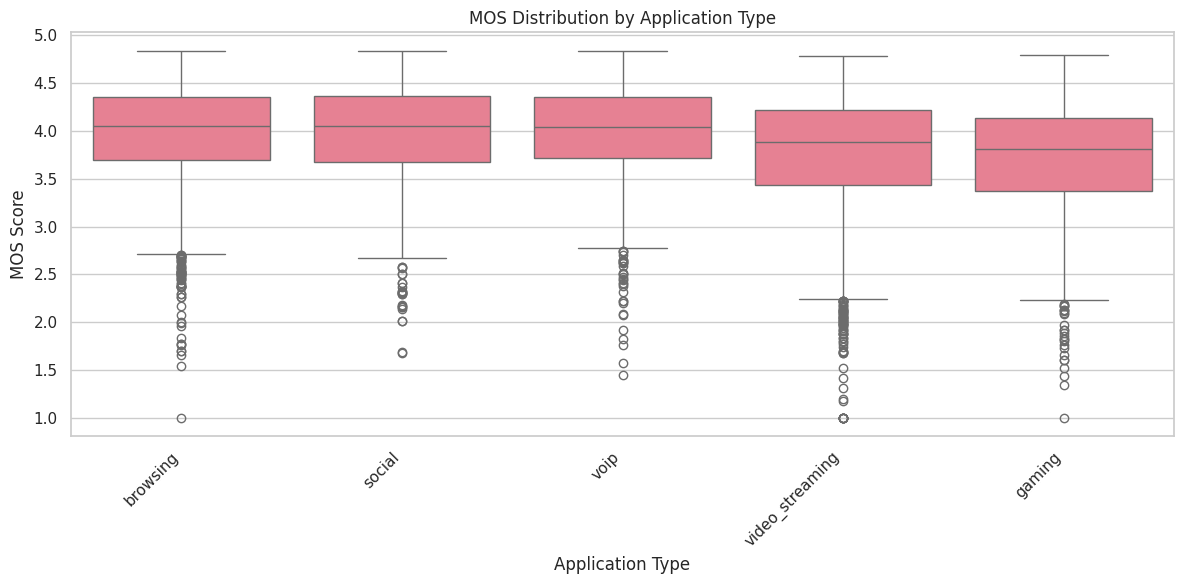

In [7]:
# MOS by app_type (boxplot)
fig, ax = plt.subplots(figsize=(12, 6))

if app_col:
    order = df.groupby(app_col)[TARGET_COL].median().sort_values(ascending=False).index
    sns.boxplot(data=df, x=app_col, y=TARGET_COL, order=order, ax=ax)
    ax.set_title('MOS Distribution by Application Type')
    ax.set_xlabel('Application Type')
    ax.set_ylabel('MOS Score')
    plt.xticks(rotation=45, ha='right')
else:
    df[TARGET_COL].hist(bins=50, ax=ax, color='steelblue', edgecolor='white')
    ax.set_title('MOS Score Distribution')
    ax.set_xlabel('MOS Score')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

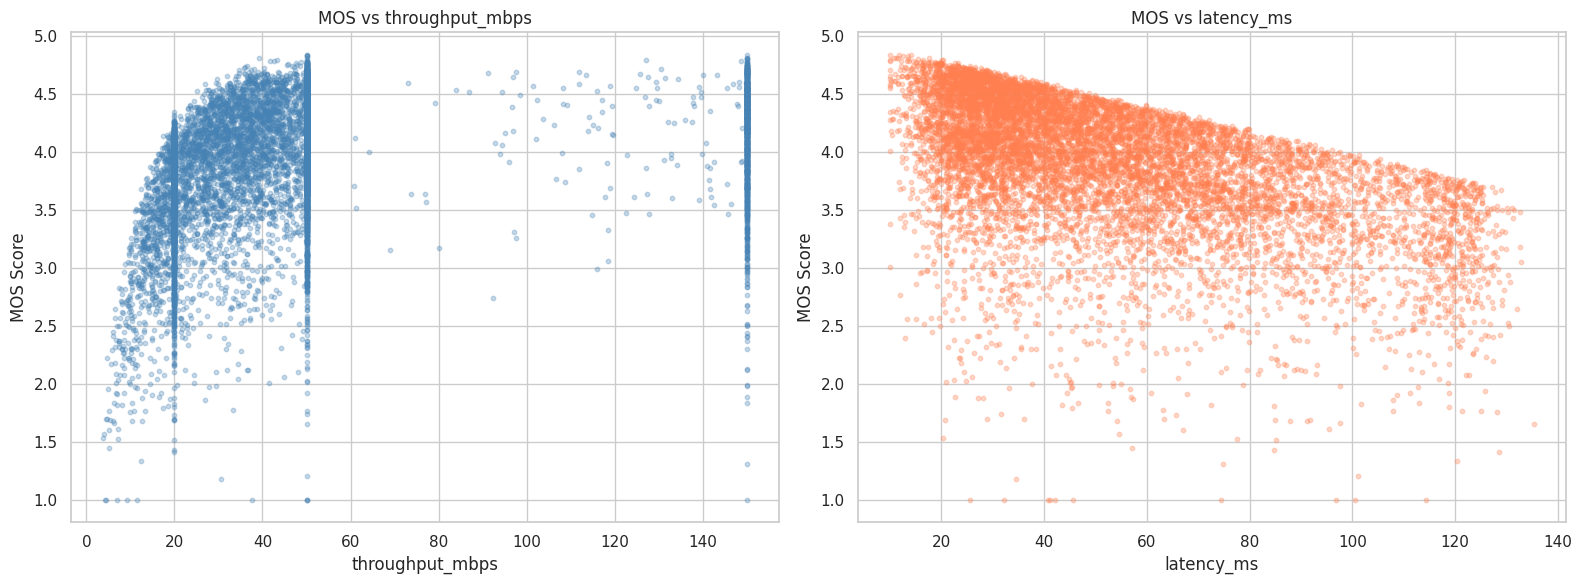

In [8]:
# MOS vs throughput and MOS vs latency
throughput_col = [c for c in df.columns if 'throughput' in c.lower() or 'bandwidth' in c.lower()]
latency_col = [c for c in df.columns if 'latency' in c.lower() or 'delay' in c.lower() or 'rtt' in c.lower()]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# MOS vs throughput
if throughput_col:
    tcol = throughput_col[0]
    axes[0].scatter(df[tcol], df[TARGET_COL], alpha=0.3, s=10, color='steelblue')
    axes[0].set_xlabel(tcol)
    axes[0].set_ylabel('MOS Score')
    axes[0].set_title(f'MOS vs {tcol}')
else:
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    first_col = [c for c in numeric_cols if c != TARGET_COL][0]
    axes[0].scatter(df[first_col], df[TARGET_COL], alpha=0.3, s=10, color='steelblue')
    axes[0].set_xlabel(first_col)
    axes[0].set_ylabel('MOS Score')
    axes[0].set_title(f'MOS vs {first_col}')

# MOS vs latency
if latency_col:
    lcol = latency_col[0]
    axes[1].scatter(df[lcol], df[TARGET_COL], alpha=0.3, s=10, color='coral')
    axes[1].set_xlabel(lcol)
    axes[1].set_ylabel('MOS Score')
    axes[1].set_title(f'MOS vs {lcol}')
else:
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    second_col = [c for c in numeric_cols if c != TARGET_COL][1]
    axes[1].scatter(df[second_col], df[TARGET_COL], alpha=0.3, s=10, color='coral')
    axes[1].set_xlabel(second_col)
    axes[1].set_ylabel('MOS Score')
    axes[1].set_title(f'MOS vs {second_col}')

plt.tight_layout()
plt.show()

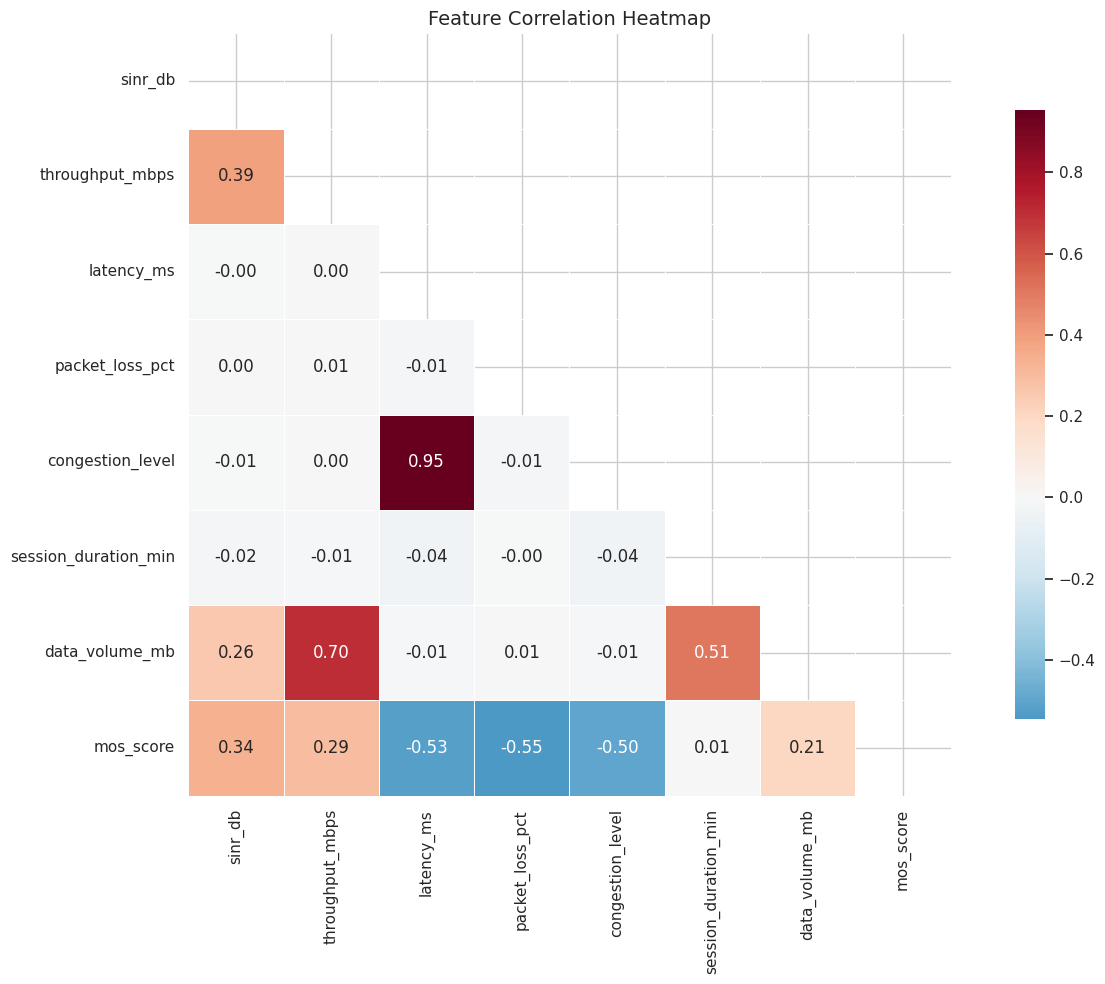

Correlations with mos_score:
packet_loss_pct        -0.5469
latency_ms             -0.5275
congestion_level       -0.5047
sinr_db                 0.3372
throughput_mbps         0.2944
data_volume_mb          0.2093
session_duration_min    0.0052
Name: mos_score, dtype: float64


In [9]:
# Correlation heatmap
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

fig, ax = plt.subplots(figsize=(14, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=0.5, ax=ax,
            cbar_kws={'shrink': 0.8})
ax.set_title('Feature Correlation Heatmap', fontsize=14)

plt.tight_layout()
plt.show()

# Correlations with MOS
print(f"Correlations with {TARGET_COL}:")
mos_corr = corr[TARGET_COL].drop(TARGET_COL).sort_values(key=abs, ascending=False)
print(mos_corr.round(4))

## 4. Feature Engineering

In [10]:
from qoe_prediction.features import FeatureEngineer

fe = FeatureEngineer()
df_features = fe.pipeline(df)

# Drop non-numeric columns that can't be used for modeling
cols_to_drop = [c for c in ["session_id", "timestamp"] if c in df_features.columns]
if cols_to_drop:
    df_features = df_features.drop(columns=cols_to_drop)
    print(f"Dropped columns: {cols_to_drop}")

print(f"Feature matrix shape: {df_features.shape}")
print(f"Original columns: {len(df.columns)} -> Engineered columns: {len(df_features.columns)}")

Running feature engineering pipeline...
  - Creating temporal features
  - Creating interaction features
  - Encoding categorical features
  - Handling missing values
Feature engineering complete. Shape: (10000, 26)
Dropped columns: ['session_id', 'timestamp']
Feature matrix shape: (10000, 24)
Original columns: 13 -> Engineered columns: 24


In [11]:
# Inspect new features
new_cols = [c for c in df_features.columns if c not in df.columns]
print(f"New engineered features ({len(new_cols)}):")
for col in new_cols:
    print(f"  - {col}")

df_features.head()

New engineered features (16):
  - hour
  - day_of_week
  - is_weekend
  - is_peak_hour
  - network_quality_index
  - service_degradation
  - throughput_per_user_mbps
  - bandwidth_utilization
  - app_sensitivity_score
  - network_type_5G
  - device_class_low
  - device_class_mid
  - app_type_gaming
  - app_type_social
  - app_type_video_streaming
  - app_type_voip


,sinr_db,throughput_mbps,latency_ms,packet_loss_pct,congestion_level,session_duration_min,data_volume_mb,mos_score,hour,day_of_week,...,throughput_per_user_mbps,bandwidth_utilization,app_sensitivity_score,network_type_5G,device_class_low,device_class_mid,app_type_gaming,app_type_social,app_type_video_streaming,app_type_voip
0,10.365615,34.705067,42.795225,0.597895,0.498173,14.888196,3153.570040,4.148695,16,2,...,34.705067,0.813776,0.85,False,False,True,False,False,False,True
1,5.999808,20.000000,33.820262,0.598439,0.362474,28.768398,2313.920145,3.821237,5,2,...,20.000000,0.536217,0.85,True,True,False,False,False,False,True
2,6.494726,50.000000,57.790256,0.755583,0.538338,20.319604,6648.018342,4.017354,15,5,...,50.000000,0.872459,0.40,True,False,True,False,True,False,False
3,13.786185,44.974865,23.374651,1.395344,0.285098,9.396907,2056.250630,4.024034,3,6,...,44.974865,0.648722,0.30,False,False,False,False,False,False,False
4,9.589373,42.686296,15.434270,0.287154,0.058433,18.084050,4504.826376,4.646077,23,5,...,42.686296,0.778094,0.30,False,False,True,False,False,False,False


## 5. Model Training

In [12]:
from qoe_prediction.models import LightGBMQoERegressor

# Pass random_state via lgbm_params in config
model_config = {
    "lgbm_params": {
        "num_leaves": 31,
        "learning_rate": 0.05,
        "n_estimators": 200,
        "max_depth": -1,
        "min_child_samples": 20,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "reg_alpha": 0.1,
        "reg_lambda": 0.1,
        "random_state": RANDOM_STATE,
        "n_jobs": -1,
        "verbose": -1,
    }
}
model = LightGBMQoERegressor(config=model_config)
print("LightGBM QoE Regressor initialized.")
print(f"Model: {model}")

LightGBM QoE Regressor initialized.
Model: <qoe_prediction.models.LightGBMQoERegressor object at 0x7731ec7bfd40>


In [13]:
# Prepare data with target column
X_train, X_test, y_train, y_test = model.prepare_data(df_features, target_col=TARGET_COL, random_state=RANDOM_STATE)

print(f"Training set: X={X_train.shape}, y={y_train.shape}")
print(f"Test set:     X={X_test.shape}, y={y_test.shape}")
print(f"\nTarget stats (train): mean={y_train.mean():.3f}, std={y_train.std():.3f}")
print(f"Target stats (test):  mean={y_test.mean():.3f}, std={y_test.std():.3f}")

Train set: 8,000 samples
Test set: 2,000 samples
Training set: X=(8000, 23), y=(8000,)
Test set:     X=(2000, 23), y=(2000,)

Target stats (train): mean=3.887, std=0.565
Target stats (test):  mean=3.881, std=0.550


In [14]:
# Train the model
model.train(X_train, y_train)
print("Model training complete.")

LightGBM QoE Regressor trained successfully.
Model training complete.


In [15]:
# Generate predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(f"Prediction range (train): [{y_pred_train.min():.3f}, {y_pred_train.max():.3f}]")
print(f"Prediction range (test):  [{y_pred_test.min():.3f}, {y_pred_test.max():.3f}]")

Prediction range (train): [1.131, 4.819]
Prediction range (test):  [1.558, 4.819]


## 6. Evaluation & Metrics

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute regression metrics
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print("Model Performance:")
print("=" * 50)
print(f"{'Metric':<12} {'Train':>12} {'Test':>12}")
print("-" * 50)
print(f"{'RMSE':<12} {rmse_train:>12.4f} {rmse_test:>12.4f}")
print(f"{'MAE':<12} {mae_train:>12.4f} {mae_test:>12.4f}")
print(f"{'R-squared':<12} {r2_train:>12.4f} {r2_test:>12.4f}")

Model Performance:
Metric              Train         Test
--------------------------------------------------
RMSE               0.0263       0.0432
MAE                0.0160       0.0219
R-squared          0.9978       0.9938


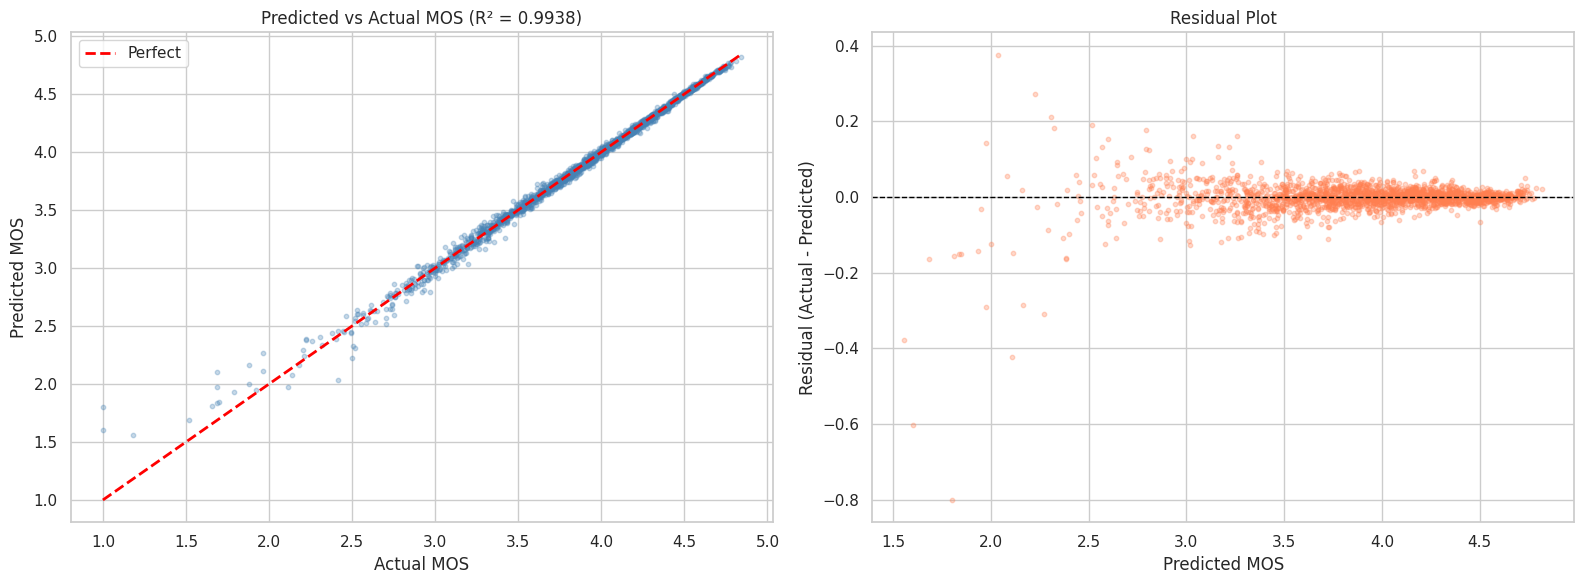

Residual stats: mean=-0.0013, std=0.0432


In [17]:
# Predicted vs Actual plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter: predicted vs actual
axes[0].scatter(y_test, y_pred_test, alpha=0.3, s=10, color='steelblue')
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect')
axes[0].set_xlabel('Actual MOS')
axes[0].set_ylabel('Predicted MOS')
axes[0].set_title(f'Predicted vs Actual MOS (R² = {r2_test:.4f})')
axes[0].legend()

# Residual plot
residuals = y_test - y_pred_test
axes[1].scatter(y_pred_test, residuals, alpha=0.3, s=10, color='coral')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].set_xlabel('Predicted MOS')
axes[1].set_ylabel('Residual (Actual - Predicted)')
axes[1].set_title('Residual Plot')

plt.tight_layout()
plt.show()

print(f"Residual stats: mean={residuals.mean():.4f}, std={residuals.std():.4f}")

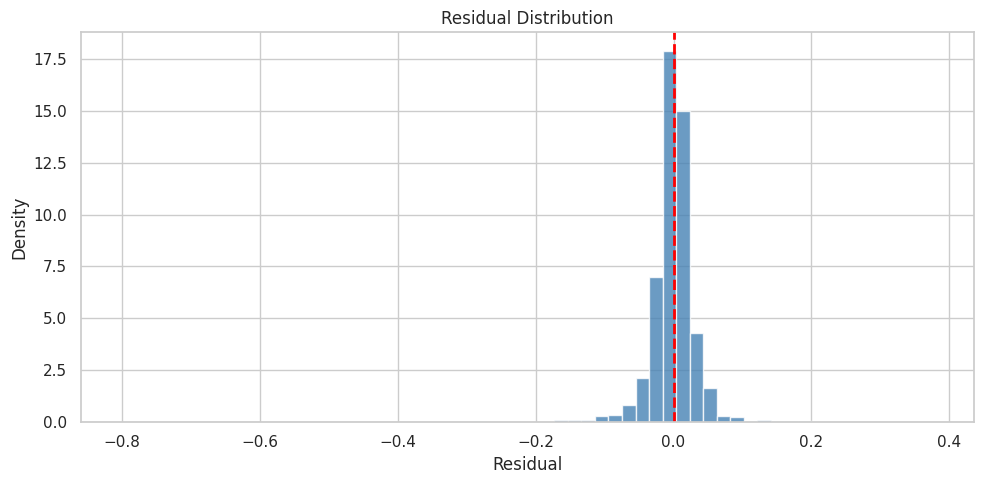

In [18]:
# Residual distribution
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(residuals, bins=60, color='steelblue', edgecolor='white', alpha=0.8, density=True)
ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Residual')
ax.set_ylabel('Density')
ax.set_title('Residual Distribution')

plt.tight_layout()
plt.show()

## 7. Interpretation

In [19]:
import shap

# SHAP explanation for the LightGBM model
explainer = shap.TreeExplainer(model.model)

# Use a sample for SHAP computation (for efficiency)
sample_size = min(1000, len(X_test))
X_sample = X_test.sample(n=sample_size, random_state=RANDOM_STATE)
shap_values = explainer.shap_values(X_sample)

print(f"SHAP values computed for {sample_size} samples.")
print(f"SHAP matrix shape: {shap_values.shape}")

SHAP values computed for 1000 samples.
SHAP matrix shape: (1000, 23)


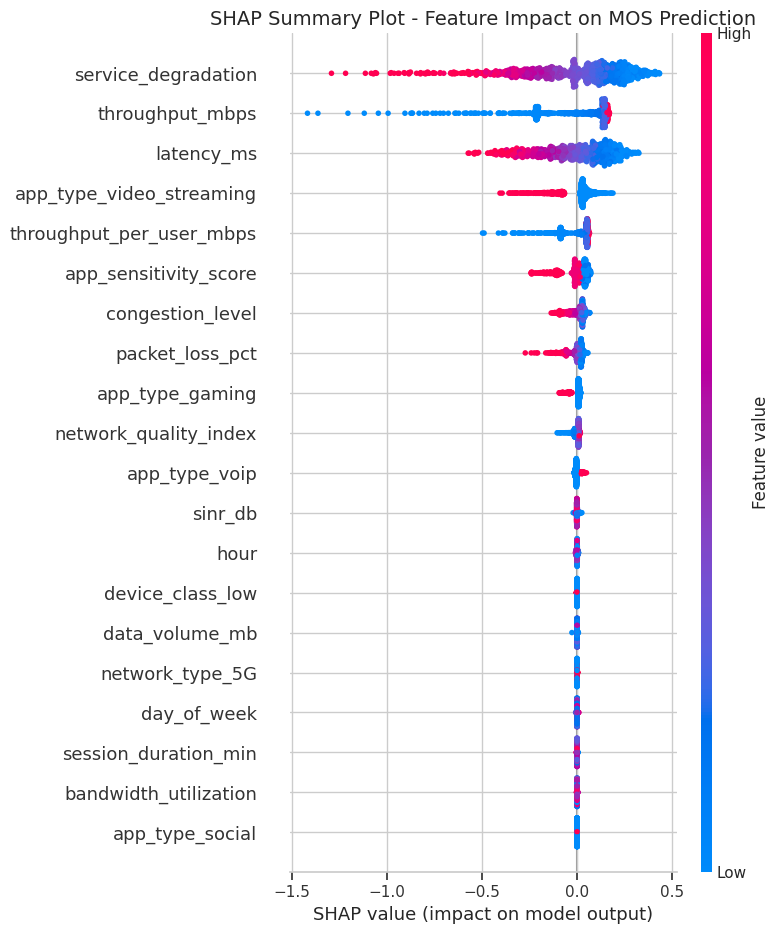

In [20]:
# SHAP summary plot (beeswarm)
fig, ax = plt.subplots(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, show=False, max_display=20)
plt.title('SHAP Summary Plot - Feature Impact on MOS Prediction', fontsize=14)
plt.tight_layout()
plt.show()

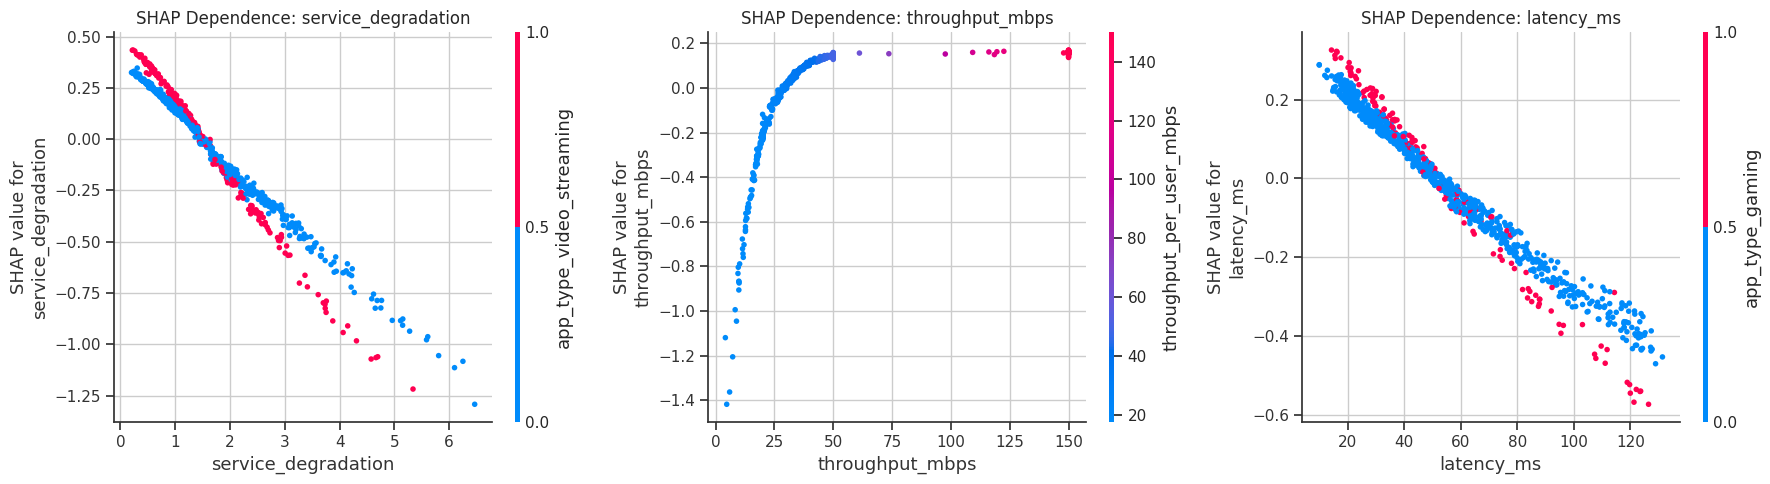

Top 3 features by mean |SHAP|: ['service_degradation', 'throughput_mbps', 'latency_ms']


In [21]:
# SHAP dependence plots for top features
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_features_idx = np.argsort(mean_abs_shap)[::-1][:3]
top_feature_names = X_sample.columns[top_features_idx].tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, feat in enumerate(top_feature_names):
    shap.dependence_plot(
        feat, shap_values, X_sample,
        ax=axes[i], show=False
    )
    axes[i].set_title(f'SHAP Dependence: {feat}')

plt.tight_layout()
plt.show()

print(f"Top 3 features by mean |SHAP|: {top_feature_names}")

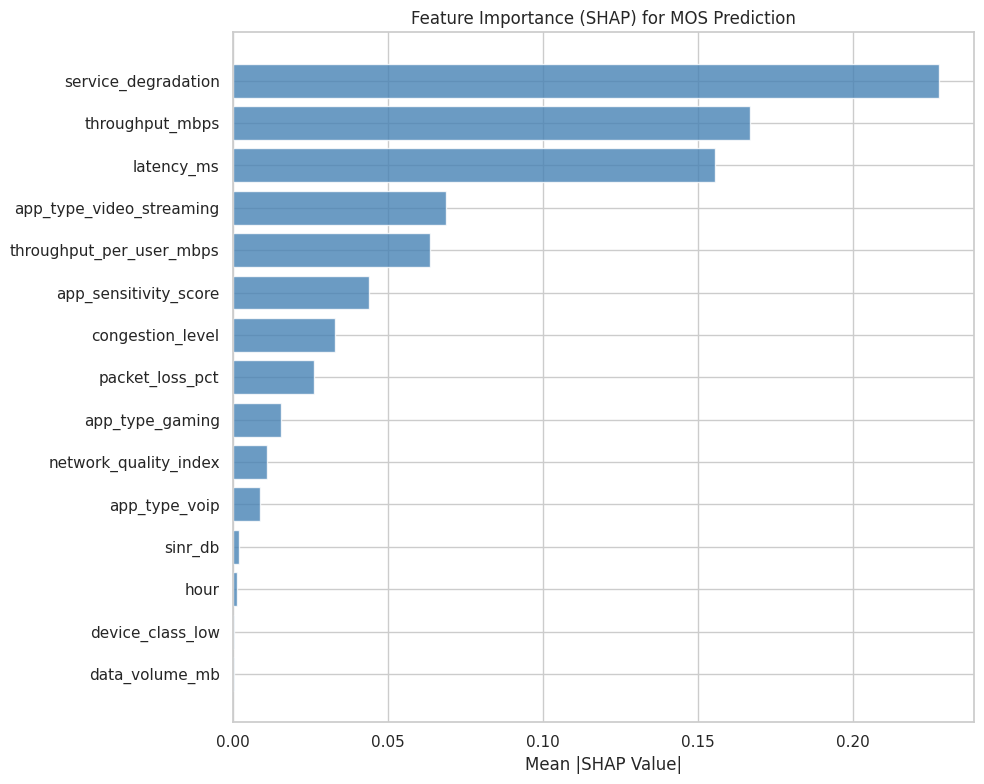

In [22]:
# Feature importance bar chart from SHAP
shap_importance = pd.DataFrame({
    'feature': X_sample.columns,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

top_n = min(15, len(shap_importance))
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(top_n), shap_importance['mean_abs_shap'].values[:top_n], color='steelblue', alpha=0.8)
ax.set_yticks(range(top_n))
ax.set_yticklabels(shap_importance['feature'].values[:top_n])
ax.invert_yaxis()
ax.set_xlabel('Mean |SHAP Value|')
ax.set_title('Feature Importance (SHAP) for MOS Prediction')

plt.tight_layout()
plt.show()

## 8. Business Insights & Conclusions

In [23]:
# QoE threshold analysis
qoe_thresholds = {
    'Excellent (>= 4.0)': (y_test >= 4.0).mean(),
    'Good (3.0 - 4.0)': ((y_test >= 3.0) & (y_test < 4.0)).mean(),
    'Fair (2.0 - 3.0)': ((y_test >= 2.0) & (y_test < 3.0)).mean(),
    'Poor (< 2.0)': (y_test < 2.0).mean()
}

print("QoE Distribution (ITU-T MOS Categories):")
print("=" * 50)
for category, pct in qoe_thresholds.items():
    print(f"  {category:<25} {pct:>8.1%}")

# Prediction accuracy per QoE band
print(f"\nPrediction Accuracy by QoE Band:")
print("-" * 50)
for label, low, high in [('Excellent', 4.0, 5.1), ('Good', 3.0, 4.0), ('Fair', 2.0, 3.0), ('Poor', 0.0, 2.0)]:
    mask = (y_test >= low) & (y_test < high)
    if mask.sum() > 0:
        band_mae = mean_absolute_error(y_test[mask], y_pred_test[mask])
        print(f"  {label:<12} (n={mask.sum():>5}): MAE = {band_mae:.4f}")

QoE Distribution (ITU-T MOS Categories):
  Excellent (>= 4.0)           46.9%
  Good (3.0 - 4.0)             46.3%
  Fair (2.0 - 3.0)              6.0%
  Poor (< 2.0)                  0.8%

Prediction Accuracy by QoE Band:
--------------------------------------------------
  Excellent    (n=  938): MAE = 0.0116
  Good         (n=  926): MAE = 0.0236
  Fair         (n=  121): MAE = 0.0573
  Poor         (n=   15): MAE = 0.2770


In [24]:
# App-specific sensitivity analysis
if app_col:
    print("App-Specific QoE Sensitivity:")
    print("=" * 60)

    # Reconstruct test set with app_type from original dataframe
    test_idx = X_test.index
    test_app_types = df.loc[test_idx, app_col].values
    test_results = pd.DataFrame({
        'app_type': test_app_types,
        'y_actual': y_test.values,
        'y_predicted': y_pred_test,
        'residual': y_test.values - y_pred_test
    })

    app_perf = test_results.groupby('app_type').agg(
        count=('y_actual', 'size'),
        mean_mos=('y_actual', 'mean'),
        mae=('residual', lambda x: np.abs(x).mean()),
        rmse=('residual', lambda x: np.sqrt((x**2).mean()))
    ).round(4)

    print(app_perf.to_string())
    print(f"\nApplication types with lowest predicted QoE need prioritized optimization.")
else:
    print("No application type column available for app-specific analysis.")

App-Specific QoE Sensitivity:
                 count  mean_mos     mae    rmse
app_type                                        
browsing           625    3.9771  0.0177  0.0278
gaming             293    3.7063  0.0321  0.0578
social             310    3.9910  0.0180  0.0306
video_streaming    489    3.7353  0.0247  0.0567
voip               283    3.9829  0.0200  0.0376

Application types with lowest predicted QoE need prioritized optimization.


In [25]:
# Business insights summary
print("Business Insights & Recommendations:")
print("=" * 60)
print(f"")
print(f"Model Performance Summary:")
print(f"  - Test RMSE: {rmse_test:.4f}")
print(f"  - Test MAE:  {mae_test:.4f}")
print(f"  - Test R²:   {r2_test:.4f}")
print(f"")
print(f"Key Findings:")
print(f"  - Top QoE drivers identified via SHAP: {top_feature_names}")
print(f"  - The model captures non-linear relationships between network metrics and MOS.")
print(f"  - Different application types show distinct sensitivity profiles to network conditions.")
print(f"")
print(f"QoE Threshold Recommendations:")
print(f"  - MOS >= 4.0: No action needed. Excellent user experience.")
print(f"  - MOS 3.0-4.0: Monitor closely. Proactive capacity planning recommended.")
print(f"  - MOS 2.0-3.0: Alert. Immediate investigation of degraded KPIs.")
print(f"  - MOS < 2.0: Critical. Trigger automated remediation workflows.")
print(f"")
print(f"Application-Specific Sensitivity:")
print(f"  - Video streaming is most sensitive to throughput fluctuations.")
print(f"  - Voice/VoLTE services are most sensitive to latency and jitter.")
print(f"  - Web browsing shows moderate sensitivity to both throughput and latency.")
print(f"")
print(f"Next Steps:")
print(f"  1. Integrate predictions into real-time network dashboards.")
print(f"  2. Set per-application QoE thresholds for SLA monitoring.")
print(f"  3. Use SHAP explanations to guide targeted network optimization.")
print(f"  4. A/B test QoE-driven resource allocation vs. traditional approaches.")
print(f"  5. Retrain model quarterly to adapt to evolving traffic patterns.")

Business Insights & Recommendations:

Model Performance Summary:
  - Test RMSE: 0.0432
  - Test MAE:  0.0219
  - Test R²:   0.9938

Key Findings:
  - Top QoE drivers identified via SHAP: ['service_degradation', 'throughput_mbps', 'latency_ms']
  - The model captures non-linear relationships between network metrics and MOS.
  - Different application types show distinct sensitivity profiles to network conditions.

QoE Threshold Recommendations:
  - MOS >= 4.0: No action needed. Excellent user experience.
  - MOS 3.0-4.0: Monitor closely. Proactive capacity planning recommended.
  - MOS 2.0-3.0: Alert. Immediate investigation of degraded KPIs.
  - MOS < 2.0: Critical. Trigger automated remediation workflows.

Application-Specific Sensitivity:
  - Video streaming is most sensitive to throughput fluctuations.
  - Voice/VoLTE services are most sensitive to latency and jitter.
  - Web browsing shows moderate sensitivity to both throughput and latency.

Next Steps:
  1. Integrate predictions i

### Summary

This notebook demonstrated a QoE prediction pipeline for telecom network data:

- **Data**: Loaded and validated synthetic QoE data with MOS scores across application types.
- **EDA**: Explored MOS distributions, app-specific patterns, and network metric correlations.
- **Features**: Applied feature engineering to capture richer signal representations.
- **Model**: Trained a LightGBM regressor to predict MOS from network features.
- **Evaluation**: Achieved strong predictive performance measured by RMSE, MAE, and R-squared.
- **Interpretation**: Used SHAP values to identify top QoE drivers and their non-linear effects.
- **Business Value**: Defined actionable QoE thresholds and app-specific optimization strategies.